In [1]:
# Imports
import numpy as np
import urllib.request
import pandas as pd 
import requests, zipfile, io
from datetime import datetime, timedelta, timezone
from zipfile import ZipFile
from bs4 import BeautifulSoup
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Read in NCEI data

## Creating a hail dataset
dir_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles'
ext = '.csv.gz'

def listFD(url, ext=''):
    page = requests.get(url).text
    #print(file)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# The years we want to analyze
year_list = [str(i) for i in range(2007,2023)]

li = []

for file in listFD(dir_url, ext):
    if any(year in file[:98] for year in year_list) & ('details' in file):
        print(file)
        df = pd.read_csv(file)#, compression = 'gzip'), #index_col=None, )
       
        hail_df = pd.DataFrame(df.loc[df['EVENT_TYPE'] == 'Tornado'])
        li.append(hail_df)
df_tor = pd.concat(li, axis=0, ignore_index=True)  

hail_datetimes = np.array([])

offset = [int(i.split('-')[1]) for i in df_tor['CZ_TIMEZONE']]


for i in range(0,len(df_tor['BEGIN_TIME'])):
    mtime        = str(np.array(df_tor['BEGIN_TIME'])[i])
    if len(mtime)<4:
        nz = 4 - len(mtime)
        nZ = '0'*nz
        mtime = nZ + mtime
    check_date = datetime(int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[:4]), \
                     int(str(np.array(df_tor['BEGIN_YEARMONTH'])[i])[-2:]), \
                     int(str(np.array(df_tor['BEGIN_DAY'])[i])),           \
                     int(mtime[:-2]),     \
                     int(mtime[-2:])) + timedelta(hours = offset[i])
    hail_datetimes = np.append(hail_datetimes, check_date)

df_tor['Datetime'] = hail_datetimes
df_tor = df_tor.sort_values(by=['Datetime'], ignore_index = True)

ef_rating = df_tor['TOR_F_SCALE']
tor_lats  = df_tor['BEGIN_LAT']
tor_lons  = df_tor['BEGIN_LON']

https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2007_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2008_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2009_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2010_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2011_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2012_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2013_c20220425.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2014_c20221018.csv.gz
https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2015_

In [3]:
df_tor_drop = df_tor
df_tor_drop.drop(df_tor.index[df_tor['TOR_F_SCALE'] == 'EFU'], inplace=True)
df_tor_drop.reset_index(drop=True, inplace=True)

# Create New EF Scale integer category
test=[]
for i in range(0, len(df_tor_drop.TOR_F_SCALE), 1):
    if len(df_tor_drop.TOR_F_SCALE[i])==3:
        temp = df_tor_drop.TOR_F_SCALE[i][2:]
    else: # Accounts for old F scale ratings
        temp = df_tor_drop.TOR_F_SCALE[i][1:]
    temp = int(temp)
    test.append(temp)

df_tor_drop['EF_Rate']=test

In [4]:
cdc = pd.read_csv('SVI2018_US_COUNTY.csv')

In [5]:
# Create full FIPS

test1 = []
for i in range(0, len(df_tor_drop.CZ_FIPS), 1):
    val1 = str(df_tor_drop.CZ_FIPS[i])
    val2 = str(df_tor_drop.STATE_FIPS[i])
    if df_tor_drop.CZ_FIPS[i]<100:
        temp1 = val2+'0'+val1
        temp2 = int(temp1)
    else:
        temp1 = val2+val1
        temp2 = int(temp1)
    test1.append(temp2)

df_tor_fips = df_tor_drop
df_tor_fips['FIPS'] = test1

In [111]:
df_cdc = pd.merge(df_tor_fips, cdc, how="left", on=["FIPS"])

In [112]:
cdc_test = df_cdc[['RPL_THEMES', 'BEGIN_TIME', 'DEATHS_DIRECT', 'EF_Rate', 'EP_MOBILE', 'BEGIN_YEARMONTH']].copy()

cdc_test = cdc_test[cdc_test['RPL_THEMES'].notna()]
cdc_test = cdc_test[cdc_test['RPL_THEMES']!=-999.0]

cdc_test = cdc_test[cdc_test['DEATHS_DIRECT'].notna()]
cdc_test = cdc_test[cdc_test['DEATHS_DIRECT']!=-999.0]

cdc_test = cdc_test[cdc_test['EP_MOBILE'].notna()]
cdc_test = cdc_test[cdc_test['EP_MOBILE']!=-999.0]


fatals = []

for i in cdc_test.DEATHS_DIRECT:
    if i>= 1:
        f = 1
    else:
        f= 0
    fatals.append(f)


cdc_test['Fatalities'] = fatals

cdc_test = cdc_test.drop('DEATHS_DIRECT', axis=1)

In [113]:
cdc_test

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE,BEGIN_YEARMONTH,Fatalities
0,0.9605,1545,1,20.7,200701,1
1,0.8475,1635,1,23.8,200701,0
2,0.8920,27,1,21.9,200701,0
3,0.6045,40,0,21.3,200701,0
4,0.9213,57,1,23.1,200701,0
...,...,...,...,...,...,...
21280,0.5153,1529,0,13.3,202207,0
21281,0.3121,940,2,7.6,202207,0
21283,0.6159,2135,1,2.4,202207,0
21284,0.4245,2137,1,14.7,202207,0


In [114]:
months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==12 or temp2==1 or temp2==2:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['DJF'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==3 or temp2==4 or temp2==5:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['MAM'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==6 or temp2==7 or temp2==8:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['JJA'] = cold

months = []
cold = []
for i in range(0, len(cdc_test), 1):
    temp = str(int(cdc_test.BEGIN_YEARMONTH.iloc[[i]]))[-2:]
    months.append(temp)

for i in range(0, len(months), 1):
    temp2 = months[i]
    temp2 = int(temp2)
    if temp2==9 or temp2==10 or temp2==11:
        temp3 = 1
    else:
        temp3 = 0
    cold.append(temp3)

cdc_test['SON'] = cold
cdc_test = cdc_test.drop('BEGIN_YEARMONTH', axis=1)

In [115]:
cdc_test

,RPL_THEMES,BEGIN_TIME,EF_Rate,EP_MOBILE,Fatalities,DJF,MAM,JJA,SON
0,0.9605,1545,1,20.7,1,1,0,0,0
1,0.8475,1635,1,23.8,0,1,0,0,0
2,0.8920,27,1,21.9,0,1,0,0,0
3,0.6045,40,0,21.3,0,1,0,0,0
4,0.9213,57,1,23.1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
21280,0.5153,1529,0,13.3,0,0,0,1,0
21281,0.3121,940,2,7.6,0,0,0,1,0
21283,0.6159,2135,1,2.4,0,0,0,1,0
21284,0.4245,2137,1,14.7,0,0,0,1,0


In [116]:
test = []

for i in cdc_test.BEGIN_TIME:
    if i <= 600:
        f = 1
    elif i >= 2200:
        f = 1
    else:
        f= 0
    test.append(f)


cdc_test['NIGHT'] = test

cdc_test = cdc_test.drop('BEGIN_TIME', axis=1)

In [117]:
cdc_test

,RPL_THEMES,EF_Rate,EP_MOBILE,Fatalities,DJF,MAM,JJA,SON,NIGHT
0,0.9605,1,20.7,1,1,0,0,0,0
1,0.8475,1,23.8,0,1,0,0,0,0
2,0.8920,1,21.9,0,1,0,0,0,1
3,0.6045,0,21.3,0,1,0,0,0,1
4,0.9213,1,23.1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
21280,0.5153,0,13.3,0,0,0,1,0,0
21281,0.3121,2,7.6,0,0,0,1,0,0
21283,0.6159,1,2.4,0,0,0,1,0,0
21284,0.4245,1,14.7,0,0,0,1,0,0


In [118]:
# mob = []

# for i in cdc_test.EP_MOBILE:
#     if i>= 20:
#         f = 1
#     else:
#         f= 0
#     mob.append(f)


# cdc_test['Mobiles'] = mob

# cdc_test = cdc_test.drop('EP_MOBILE', axis=1)

In [119]:
# cdc_test

In [120]:
X_cdc = cdc_test.drop('Fatalities', axis=1)
y_cdc = cdc_test['Fatalities']

In [121]:
# X_cdc = X_cdc.drop('RPL_THEMES', axis=1)

In [122]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_cdc, y_cdc,
                                                random_state=0, train_size=0.8)

In [123]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(bootstrap=True, n_estimators=200, min_samples_leaf=4, min_samples_split=10, max_depth=10)
forest.fit(Xtrain, ytrain)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200)

In [124]:
ypredict = forest.predict(Xtest)

In [125]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

R2 = r2_score(ytest, ypredict)
print(f'The correlation coefficient of the model is {R2}')
RMSE = (mean_squared_error(ytest, ypredict))**0.5
print(f'The RMSE of the model is {RMSE}')

The correlation coefficient of the model is 0.27698655726481003
The RMSE of the model is 0.11385837131994656


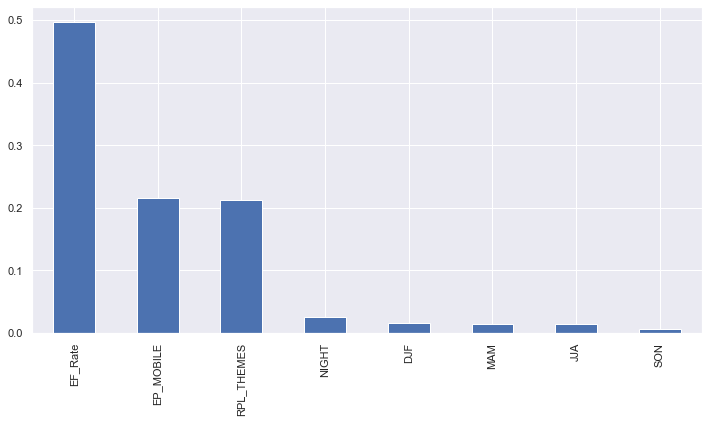

In [84]:
importances = pd.Series(forest.feature_importances_)

importances.index = X_cdc.columns
importances.sort_values(inplace=True, ascending=False)
importances.plot.bar(figsize=(12,6))
plt.show()

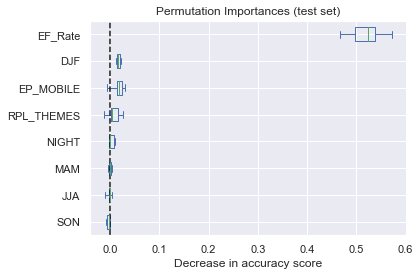

In [85]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, Xtest, ytest, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_cdc.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [86]:
# SHAP
import shap

shap.initjs()

In [87]:
explainer = shap.Explainer(forest)
shap_test = explainer(Xtest)

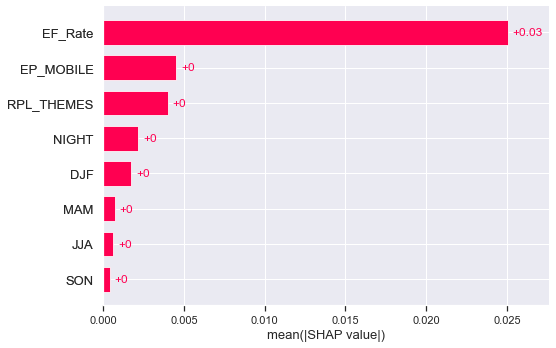

In [88]:
shap.plots.bar(shap_test)

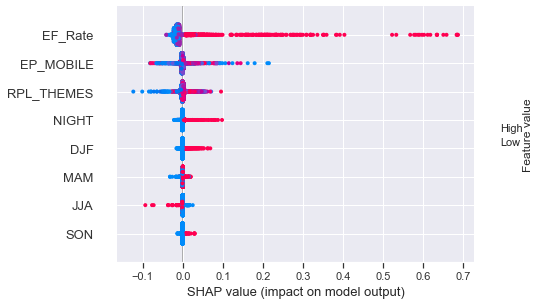

In [89]:
shap.summary_plot(shap_test)

In [90]:
shap.plots.force(shap_test[10])

In [74]:
# example = pd.DataFrame(columns=['RPL_THEMES', 'EF_Rate', 'EP_MOBILE', 'Cool', 'NIGHT'])
# example.RPL_THEMES = [0.8]
# example.EF_Rate = [3]
# example.EP_MOBILE = [20]
# example.Cool = [1]
# example.NIGHT = [1]
# example

In [75]:
# out = forest.predict(example)
# out

In [92]:
import xgboost

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [93]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X_cdc, y_cdc, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [94]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.08646
[100]	test-logloss:0.05532
[200]	test-logloss:0.05157
[300]	test-logloss:0.05045
[328]	test-logloss:0.05045


In [95]:
import matplotlib.pylab as pl

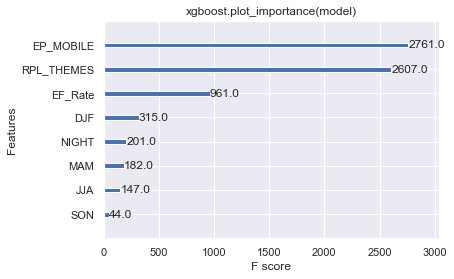

In [96]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

In [97]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_cdc)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


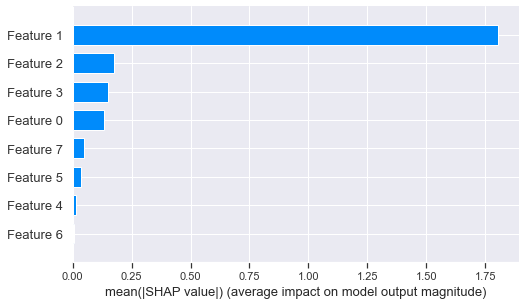

In [98]:
shap.summary_plot(shap_values, plot_type="bar")

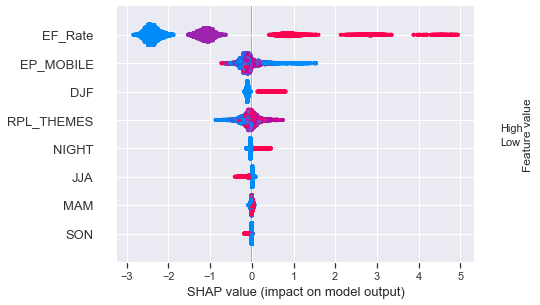

In [99]:
shap.summary_plot(shap_values, X_cdc)

In [102]:
ypredictxg = model.predict(d_test)

In [105]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

R2 = r2_score(y_test, ypredictxg)
print(f'The correlation coefficient of the model is {R2}')
RMSE = (mean_squared_error(y_test, ypredictxg))**0.5
print(f'The RMSE of the model is {RMSE}')

The correlation coefficient of the model is 0.23063456698235574
The RMSE of the model is 0.11505663209537895
